<a href="https://colab.research.google.com/github/nklsKrmnn/LSC_Sentiment_Analysis/blob/main/Projekt_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
try:
  import transformers
except:
  %pip install -q transformers
  import transformers

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from transformers import BertTokenizer, BertModel, BertConfig
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch import cuda

device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [22]:
train_set = pd.read_csv("/content/drive/MyDrive/train.tsv", sep='\t')

<Axes: xlabel='Sentiment', ylabel='count'>

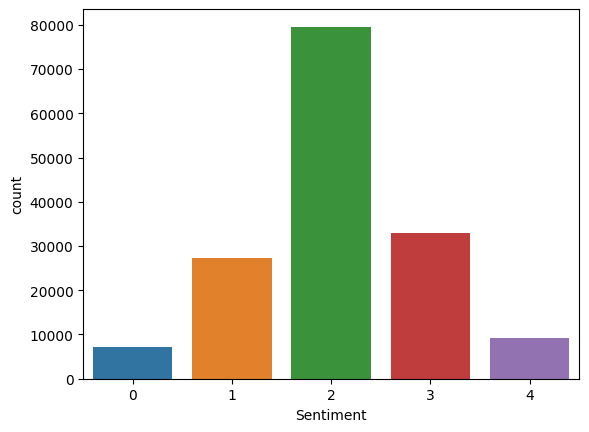

In [23]:
sns.countplot(x='Sentiment', data=train_set)
# --> The classes are not equaly represented. We need to agument or bootstrap

In [24]:
train_set_full_sentences = train_set.groupby('SentenceId').first().reset_index()
train_set_full_sentences.head()

,SentenceId,PhraseId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,64,"This quiet , introspective and entertaining in...",4
2,3,82,"Even fans of Ismail Merchant 's work , I suspe...",1
3,4,117,A positively thrilling combination of ethnogra...,3
4,5,157,Aggressive self-glorification and a manipulati...,1


<Axes: xlabel='Sentiment', ylabel='count'>

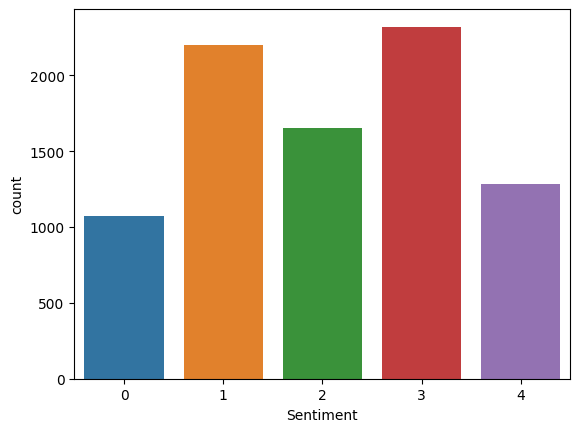

In [25]:
sns.countplot(x='Sentiment', data=train_set_full_sentences)
# --> besser

In [26]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 20
VALID_BATCH_SIZE = 50
EPOCHS = 2
LEARNING_RATE = 1e-04
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [27]:
class dataset(Dataset):

    def __init__(self, input, targets, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.input = input
        self.targets = targets
        self.max_len = max_len

    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        text = str(self.input[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets.iloc[index].values, dtype=torch.float)
        }

In [28]:
data_preprocessed = train_set_full_sentences.join(pd.get_dummies(train_set_full_sentences['Sentiment'], dtype=float)).drop('Sentiment', axis=1)
setsize = data_preprocessed.shape[0]/8
limits = []
datasets = []
for _ in range(8):
  limits.append((_*setsize, (_+1)*setsize))
  datasets.append(data_preprocessed.loc[_*setsize:(_+1)*setsize, :])

In [29]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 5)

    def forward(self, ids, mask, token_type_ids):
        _, output_1 = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

In [30]:
model = BERTClass()
model.load_state_dict(torch.load("/content/drive/MyDrive/model.pth"))
model.to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [31]:
def train(epoch, training_loader):
    model.train()
    for _, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _ % 20 == 0:
          torch.save(model.state_dict(), "/content/drive/MyDrive/model.pth")
          print("Model saved")
        print(f'Epoch: {epoch}, Batch: {_}, Loss:  {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [32]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

In [33]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [34]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
              'shuffle': True,
              'num_workers': 0
              }

test_params = {'batch_size': VALID_BATCH_SIZE,
              'shuffle': True,
              'num_workers': 0
              }

start_index = 4

for epoch in range(EPOCHS):
  test_dataset = datasets[7]
  train_dataset = datasets[start_index + epoch%7]

  print("FULL Dataset: {}".format(train_set_full_sentences.shape))
  print("TRAIN Dataset: {}, Shape: {}".format(int(train_dataset['SentenceId'].min()/setsize), train_dataset.shape))
  print("TEST Dataset: {}, Shape: {}".format(int(test_dataset['SentenceId'].min()/setsize), test_dataset.shape))

  test_dataset = test_dataset.reset_index(drop=True)
  train_dataset = train_dataset.reset_index(drop=True)

  training_set = dataset(train_dataset['Phrase'], train_dataset.loc[:, 0:], tokenizer, MAX_LEN)
  testing_set = dataset(test_dataset['Phrase'], test_dataset.loc[:, 0:], tokenizer, MAX_LEN)

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)

  train(epoch, training_loader)


  torch.save(model.state_dict(), "/content/drive/MyDrive/model.pth")

FULL Dataset: (8529, 4)
TRAIN Dataset: 4, Shape: (1066, 8)
TEST Dataset: 7, Shape: (1066, 8)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Model saved
Epoch: 0, Batch: 0, Loss:  1.1724627017974854
Epoch: 0, Batch: 1, Loss:  1.532577395439148
Epoch: 0, Batch: 2, Loss:  1.0837234258651733
Epoch: 0, Batch: 3, Loss:  1.1496617794036865
Epoch: 0, Batch: 4, Loss:  1.051081657409668
Epoch: 0, Batch: 5, Loss:  1.2894095182418823
Epoch: 0, Batch: 6, Loss:  1.2638428211212158
Epoch: 0, Batch: 7, Loss:  1.7747074365615845
Epoch: 0, Batch: 8, Loss:  1.254724383354187
Epoch: 0, Batch: 9, Loss:  1.3621232509613037
Epoch: 0, Batch: 10, Loss:  1.2748864889144897
Epoch: 0, Batch: 11, Loss:  0.924132764339447
Epoch: 0, Batch: 12, Loss:  1.195492148399353
Epoch: 0, Batch: 13, Loss:  1.1875011920928955
Epoch: 0, Batch: 14, Loss:  1.018316626548767
Epoch: 0, Batch: 15, Loss:  1.499009132385254
Epoch: 0, Batch: 16, Loss:  1.2865041494369507
Epoch: 0, Batch: 17, Loss:  1.1418707370758057
Epoch: 0, Batch: 18, Loss:  1.2104225158691406
Epoch: 0, Batch: 19, Loss:  1.2505778074264526
Model saved
Epoch: 0, Batch: 20, Loss:  1.4239076375961304
Epoch:

In [35]:
def validation(epoch):
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [36]:
for epoch in range(EPOCHS):
    outputs, targets = validation(epoch)
    outputs = np.array(outputs).argmax(axis=1)
    targets = np.array(targets).argmax(axis=1)
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.46810506566604126
F1 Score (Micro) = 0.46810506566604126
F1 Score (Macro) = 0.3264366796614784


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Accuracy Score = 0.46810506566604126
F1 Score (Micro) = 0.46810506566604126
F1 Score (Macro) = 0.3264366796614784
